In [672]:
import numpy as np 
import pandas as pd
import csv
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
import emoji
import string
import json
import nltk

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# list of all the dataset files
dataset_paths = ["../../../datasets/russia_052020_tweets_csv_hashed_2.csv", 
         "../../../datasets/russian_linked_tweets_csv_hashed.csv", 
         "../../../datasets/ira_tweets_csv_hashed.csv", 
         "../../../datasets/russia_201906_1_tweets_csv_hashed.csv"]

# path to store the entire combined dataset
combined_dataset_path = "../datasets/russian_trolls.csv"

# returns a pandas dataframe consisting of entries from all the dataset files
def get_combined_dataset(paths):
    data = pd.concat((pd.read_csv(file) for file in tqdm(paths)))
    return data

data = get_combined_dataset(dataset_paths)
print("Number of tweets in the dataset: ", data.shape[0])


100%|██████████| 4/4 [01:04<00:00, 16.04s/it]


Number of tweets in the dataset:  9995700


In [ ]:

# # extracts just the english tweets by using the language tag
# is_english_tweet = data['tweet_language'] == 'en'
# english_data = data[is_english_tweet]

# print("Number of English tweets in the dataset: ", english_data.shape[0])
# english_tweet_data = english_data[['tweetid', 'tweet_text']]

# takes list of tweets as input and returns list of pre-processed tweets as output
def preprocess(tweets):
    processed_tweets = []
    for tweet in tweets:
        result = re.sub(r"http\S+", "", tweet)
        result = re.sub(r"RT @\S+", "", result)
        result = re.sub(r"@\S+", "", result)
        result = re.sub(emoji.get_emoji_regexp(), "", result)
        result_removed_punctuation = result.translate(str.maketrans('', '', string.punctuation))
        result = re.sub(r"[^a-zA-Z0-9 ]", "", result_removed_punctuation)
        processed_tweets.append(result)
    return processed_tweets

# Filtering data between 01.01.2019 to 01.07.2017
data['tweet_time'] = pd.to_datetime(data['tweet_time'], format = '%Y-%m-%d')
start_date = '2016-01-01'
end_date = '2017-07-01'
mask = (data['tweet_time'] > start_date) & (data['tweet_time'] <= end_date)
data = data.loc[mask]
print("Number of tweets in the dataset after filtering: ", data.shape[0])


# extracts just the english tweets by using the language tag
is_english_tweet = data['tweet_language'] == 'en'
f_english_data = data[is_english_tweet]
print("Number of English tweets in the filtered dataset: ", f_english_data.shape[0])



In [636]:
is_retweet = f_english_data['retweet_tweetid'].notnull()
f_english_data = f_english_data[~is_retweet]
print("Number of entries in the dataset after removing retweets: ", f_english_data.shape[0])

Number of entries in the dataset after removing retweets:  622424


In [637]:
f_english_tweet_data = f_english_data[['tweetid', 'tweet_text']]

tweets = f_english_tweet_data['tweet_text']
tweets = preprocess(tweets)

f_english_tweet_data = f_english_tweet_data.assign(processed_tweets = tweets)

# removes the entries having empty string after preprocessing
is_not_empty_string = f_english_tweet_data['processed_tweets'].apply(lambda x: not str.isspace(x))
f_english_tweet_data = f_english_tweet_data[is_not_empty_string]
print("Number of english tweets after filtering and preprocessing before dropping the duplicates: ", f_english_tweet_data.shape[0])
f_english_tweet_data.drop_duplicates(subset ="tweetid", keep = 'first', inplace = True)
f_english_tweet_data.drop_duplicates(subset ="processed_tweets", keep = 'first', inplace = True)
f_english_tweet_data = f_english_tweet_data.reset_index()
print("Number of english tweets after filtering and preprocessing and dropping the duplicates: ", f_english_tweet_data.shape[0])

Number of english tweets after filtering and preprocessing before dropping the duplicates:  622423
Number of english tweets after filtering and preprocessing and dropping the duplicates:  559477


In [638]:

encodings = np.load('../encodings_stsb_roberta_large_fixed_retweet.npy')

# normalizes the vectors in ndarray row wise
def normalize_rows(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)


In [639]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [644]:
from sklearn.cluster import DBSCAN
import numpy as np
             
X = normalize_rows(encodings)
start_time_c = time.perf_counter()
clustering = DBSCAN(eps = 0.3, min_samples = 5, metric = 'cosine').fit(X)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c - start_time_c)/60.0, " minutes.")
# print(clustering.labels_)


Time taken for clustering is : 160.7855995643108  minutes.


In [645]:
u, c = np.unique(clustering.labels_, return_counts = True)

In [646]:
c

array([307798, 233165,      5, ...,      5,      5,      4])

In [ ]:
ref_df = pd.DataFrame()
ids = (f_english_tweet_data['tweetid']).astype(str).tolist()
tweets = f_english_tweet_data['processed_tweets'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = clustering.labels_


In [ ]:
ref_df = ref_df.sort_values('cluster_label')

In [105]:
text = (f_english_tweet_data.loc[f_english_tweet_data['tweetid'] == 862665963640045568])['processed_tweets']
text

81983     Moderate Muslim An Oxymoron that only morons can believe  29Apr
Name: processed_tweets, dtype: object

In [92]:
ref_df.iloc[99359:99859]

,tweet_text,tweetid,cluster_label
50254,Nice bounce cartoon TCOT LNYHBT MAGA DrainTheSwamp BuildTheWall Covfefe kathygriffin,870728842012368896,267
50278,Liberal safe space 2017 Lisa Benson cartoon TCOT LNYHBT MAGA DrainTheSwamp BuildTheWall,857273080770576384,267
50276,Let me get this straight Cartoon Manchester MAGA KAG TCOT LNYHBT DrainTheSwamp BuildTheWall,867425894389829632,267
50288,Please stay Please cartoon TCOT LNYHBT MAGA DrainTheSwamp BuildTheWall,864890460753371136,267
50324,Recently I received a warning MAGA KAG TCOT LNYHBT DrainTheSwamp BuildTheWall IslamIsTheProblem StopIslam,869606554600849408,267
50131,Make Little Sisters Great Again cartoon TCOT LNYHBT MAGA DrainTheSwamp BuildTheWall,862293091268517888,267
50184,Not like I did cartoon MAGA KAG TCOT LNYHBT DrainTheSwamp BuildTheWall,862293046963994625,267
50013,Sling it Ronny Gordon cartoon WALL ThankYouTrump MAGA KAG TCOT LNYHBT DrainTheSwamp BuildTheWall,825955225680781313,267
50026,Thanks Dims cartoon TCOT LNYHBT MAGA DrainTheSwamp BuildTheWall,847707003979837440,267
50032,We interrupt collision coverage cartoon TCOT LNYHBT MAGA DrainTheSwamp BuildTheWall Manchester,867781055209537536,267


In [63]:
ref_df.iloc[75359:100000].to_csv('deduplicatedCluster100Keps30density5WithIds.csv')

# Clustering with HDBSCAN

In [264]:
import hdbscan

start_time_c = time.perf_counter()
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(encodings[:100000])
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c - start_time_c)/60.0, " minutes.")

Time taken for clustering is : 339.17478093150226  minutes.


In [265]:
cluster_labels
u, c = np.unique(cluster_labels, return_counts = True)

In [266]:
c

array([93427,     7,     5,     7,     5,     7,     9,     7,     9,
           7,     9,    18,    12,     6,    14,     7,     7,    11,
           7,     5,     6,    18,     5,     7,     6,     8,     6,
           7,     5,    10,    11,    16,     5,     5,     7,    10,
          14,     5,     8,    15,     5,     5,     6,    15,     6,
           6,    23,     9,     9,     5,     9,     5,     6,    10,
           5,     6,    11,     8,     5,     8,     5,     8,     5,
           8,     6,    11,     5,     7,     8,     5,     6,     6,
           5,    15,     5,     7,     5,     6,     9,    11,     5,
          19,     5,     5,     6,     8,    25,    13,     7,     5,
           8,     8,     6,     7,     5,     9,     6,     9,     5,
           6,    12,     6,    23,     9,     5,     5,     9,     6,
          18,     5,     6,     5,     5,     5,     8,    10,     5,
          13,     5,     6,    13,    10,    10,     7,    11,     6,
           5,     5,

In [267]:
ref_df = pd.DataFrame()
ids = ((f_english_tweet_data.head(100000))['tweetid']).astype(str).tolist()
tweets = (f_english_tweet_data.head(100000))['processed_tweets'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = cluster_labels


In [268]:
ref_df = ref_df.sort_values('cluster_label')

In [269]:
ref_df.to_csv('hdbscan_100000.csv')

## Analysing HDBSCAN results

In [647]:
hdb_df = pd.read_csv('hdbscan100k.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'hdbscan100k.csv'

In [173]:
u, c = np.unique(hdb_df['cluster_label'].tolist(), return_counts = True)

In [174]:
u

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [175]:
c

array([93843,     9,     7,     7,     6,     6,     6,     7,    10,
           7,     7,     5,     5,    10,     6,    15,     6,     5,
           7,     7,    20,    10,     5,    15,     5,     7,    11,
           8,     5,     6,     8,     8,     6,     5,    22,     6,
           6,     8,    14,     5,     8,     5,     6,     5,     5,
           6,     7,    13,     6,    13,     6,     6,    17,     6,
           8,     6,    10,     9,     8,     6,    17,     6,     7,
           7,     9,     6,     6,     5,     7,     6,    10,     5,
           5,    22,     6,     5,    11,    10,     5,     9,     6,
           7,     6,     6,    10,     5,     6,     5,     8,    17,
          15,     9,    12,    10,     9,     8,     8,     7,     5,
          10,     5,     8,     8,     5,    12,     7,     9,     5,
           5,     5,    11,     7,     7,     6,     5,     9,    10,
          10,    19,     6,    48,     5,     7,     5,     6,    10,
          11,     6,

In [76]:
hdb_df.iloc[75359:100000].to_csv('hdbscan100ktweetsremovedMinus1.csv')

# Reclustering big clusters using DBSCAN

In [116]:
from sklearn.cluster import DBSCAN
import numpy as np
             
X = normalize_rows(encodings[0:100000])
start_time_c = time.perf_counter()
clustering = DBSCAN(eps = 0.3, min_samples = 5, metric = 'cosine').fit(X)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c - start_time_c)/60.0, " minutes.")
# print(clustering.labels_)


Time taken for clustering is : 1.5462503348166743  minutes.


In [117]:
u, c = np.unique(clustering.labels_, return_counts = True)
print(c)

[75359 21446    23     6    21     5     7    14    10    12    18     6
     7    11     4     3    14    32     6    56    27     5    94    37
    10     5     7     3     6     7    27     5     5     5     6    92
    15     9    35    13     5     7    14     7     9     5    12     5
    21     7    17     5    11     5     5    15     5     8     7     5
     5     4     9     8    15     7    15     5     5    22    15    13
     6    16     6     7    13     6     5     5     6    10    12     9
    13     9     5    11     5     9     4     6    22     8    10    10
     9     5    18     5     8     8     5     5     5     5     8    12
     4     5     6     9    10     4    13     7    18     8     4     5
     7    14     9    12    12     5    28    18     7     9    10     4
     5     6     8     6     7     3     5    10    10     4     4     9
    18     6     7    14     4     5     5     5     6     6    12     7
     5     7     5    18     5    13     5    12   

In [118]:
ref_df = pd.DataFrame()
ids = ((f_english_tweet_data.head(100000))['tweetid']).astype(str).tolist()
tweets = (f_english_tweet_data.head(100000))['processed_tweets'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = clustering.labels_
ref_df = ref_df.sort_values('cluster_label')

In [119]:
cluster_0 = ref_df.index[ref_df['cluster_label'] == 0].tolist()

In [120]:
cluster_0_encodings = [encodings[i] for i in cluster_0]

In [121]:
start_time_c = time.perf_counter()
clustering = DBSCAN(eps = 0.2, min_samples = 5, metric = 'cosine').fit(cluster_0_encodings)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c - start_time_c)/60.0, " minutes.")

Time taken for clustering is : 0.049670699182509756  minutes.


In [123]:
u, c = np.unique(clustering.labels_, return_counts = True)
print(u)

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148]


# Analysing the clustering of entire 700k tweets using DBSCAN

In [77]:
entire_df = pd.read_csv('./clusteringEntireIndexWithoutNjobsWithids.csv')

In [78]:
u, c = np.unique(entire_df['cluster_label'].tolist(), return_counts = True)

In [84]:
c


array([462322, 270764,     84, ...,      6,      5,      5])

In [82]:
entire_df.iloc[733086:].to_csv('clusteringEntireIndexremovedMinus1.csv')

# CDF plot of number of words per tweet

In [141]:
tweets = f_english_tweet_data['processed_tweets'].tolist()

In [144]:
lengths = []
singles = []
doubles = []
for t in tweets:
    l = len(t.split())
    lengths.append(l)
#     print(l)
    if l == 1:
        
        singles.append(t)
    elif l== 2:
        doubles.append(t)
print(len(tweets), len(lengths))

749295 749295


In [150]:
dict = {'doubles': doubles}  
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('wordCountsDoubles.csv')

/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  


Text(0, 0.5, 'distribution of 700K tweets')

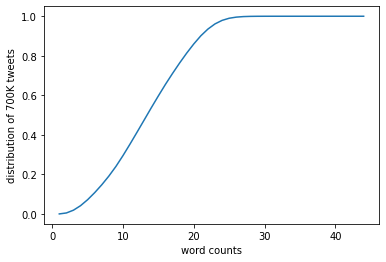

In [133]:
bins = np.arange(0,45, 1)
counts, bin_edges = np.histogram (lengths, bins=bins, normed=False)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('word counts')
plt.ylabel('distribution of 700K tweets')

In [134]:
print(counts)

[    0  3615 10518 17042 22663 26761 29763 32940 36640 41199 43949 45391
 45935 46131 44947 43717 41315 39620 37451 34642 31036 25437 19583 13318
  8096  4228  2046   837   318   101    31    15     3     2     0     1
     2     0     1     0     0     0     1     0]


In [135]:
print(bin_edges)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


# HDBSCAN entire index

In [557]:
hdb_entire_df = pd.read_csv('hdbscanEntire.csv')

In [270]:
hdb_100k_df = pd.read_csv('hdbscan_100000.csv')


In [279]:
tids = hdb_100k_df['tweetid'].tolist()
tids = tids[93843:]
filtered = hdb_entire_df[hdb_entire_df['tweetid'].isin(tids)]

In [294]:
filtered[filtered['cluster_label']== -1]


,Unnamed: 0,tweet_text,tweetid,cluster_label
390911,99824,MarkLevin on Obama Wiretapping Trump Is the Victim ObamaGate,838488009972428801,-1
390981,99877,Thanks to all that have served and still serving ThankYouForYourService,737406131090247680,-1
391006,99688,America needs MakeAmericaGreatAgain trump2016,698565624751091713,-1
391055,99741,READ Trump letter to Comey,862216514253889536,-1
391179,99923,Trump order gives Mnuchin green light to take first step on tax reform,855572100081369089,-1
391193,99893,Go West Virginia Trump2016 MakeAmericaGreatAgain,728730408121040897,-1
391198,99898,Happy Anniversary TeamTrump MakeAmericaGreatAgain Trump2016,743509849128894465,-1
392042,98567,HillaryClintonNo Time2See 13Hours Movie Re BenghaziNoTime 4 100s Emails Fr Embassy Ag Terrorismmillennials NH htt,688912072222965760,-1
392046,98562,Gays ISLAM HATES YOU GaysForTrump,742876383970353152,-1
392151,98836,HamasCAIR Leader Calls For Overthrow Of US Government Hungary ukip,805962543659249665,-1


In [292]:
filtered.shape

(6157, 4)

In [308]:
observed_data = []

In [344]:
hdb_100k_df[hdb_100k_df['tweetid'] == 692885249810780160]

,Unnamed: 0,tweet_text,tweetid,cluster_label
99626,98457,Thank you for what your doing to support Veterans Thank you from the bottom of my heart Se,692885249810780160,395


In [327]:
selected_data = hdb_100k_df[hdb_100k_df['cluster_label'] == 367]
selected_data

,Unnamed: 0,tweet_text,tweetid,cluster_label
97309,252,Todays Lesson On Islam IslamIsTheProblem BanTheQuranAsAHATEBOOK EducateYoureOnIslam StopImportingIslam NoMoreMus,860466235070234624,367
97310,251,Todays Lesson On Islam StopMakingExcusesForIslam IslamophobiaIsALie StopOppressedWomen BanShariaLaw EvilIsEvil I,868750368632586240,367
97311,250,Todays Lesson On Islam IslamIsNotAReligionIslamIsTheProblemTheQuranIsTheProblem UniteAgainstIslam StopI,880605938075353089,367
97312,249,Todays Lesson On Islam DeathCult IslamIsTheProblem IslamIsPureEvil ProudInfidel Infidel4Life BanShariah BanTheQ,855482529884717056,367
97313,272,Todays Lesson On Islam IslamIsTheProblem BanTheQuran BanTheBurka BanIslam EndIslam STOPIslam StopImportingIslam,860537339189252100,367
97314,248,Todays Lesson On Islam WakeUpWorld IslamIsTheProblem StopImportingIslam StopMakingExcusesForIslam SayNoToIslam Neve,872606215896879104,367
97315,265,Todays Lesson On Islam StopImportingMoslemscum StopImportingMoslemscum StopImportingMoslemscum StopImportingMoslem,870079421679419395,367
97316,271,Todays Lesson On Islam StopImportingIslam StopMakingExcuesesForIslam ExposeIslam STOPIslam BanTheQuranAsAHATEBOOK,866951446654197761,367
97317,247,Todays Lesson On Islam Islam STOPIslam StopMakingExcusesForIslam StopImportingIslam BanShariaLaw BanTheQuran I,859618294181109760,367
97318,274,Todays Lesson On Islam IslamIsTheProblemISISisIslam ItsGoingToBeIslam NothingToDoWithIslam StopImportingM,880846277700755460,367


In [328]:
selected_data = hdb_100k_df[hdb_100k_df['cluster_label'] == 367]
del selected_data['Unnamed: 0']
observed_data.append(selected_data.to_dict(orient = 'records'))

In [332]:
obs_data = []
for l in observed_data:
    for i in l:
        obs_data.append(i)
    

In [392]:
hdb_entire_df[hdb_entire_df['tweetid'] == 866965681140518915]

,Unnamed: 0,tweet_text,tweetid,cluster_label
741060,204,Todays Lesson On Islam IslamIsTheProblem ExposeIslam StopMakingExcusesForIslam NoMoreMoslemRefugees BanIslamSupre,866965681140518915,3626


In [385]:
selected_data = hdb_entire_df[hdb_entire_df['cluster_label'] == 3626]
selected_data

,Unnamed: 0,tweet_text,tweetid,cluster_label
741022,25763,Todays Lesson On Islam Islam IslamIsTheProblem IslamIsEvil BanShariaLaw BanTheQuran StopImportingIslam MuslimBa,851619933679042560,3626
741023,3494,Todays Lesson On Islam FitInOrGetOut NoMoreMoslemRefugees StopImportingIslam IgnorantLiberals CloseALLMosquesNOW Ban,874569834327023616,3626
741024,3515,Todays Lesson On Islam RealWarOnWomen BanShariaLaw BanTheQuran BanTheMuslimBrotherhood BanCAIRNational IslamIsThePr,880602102422282240,3626
741025,20473,Todays Lesson On Islam DeportALLMoslems CloseALLMosques BanShariaLaw BanIslam StopImportingIslam EnoughIsEnough,878724842970730496,3626
741026,48377,Todays Lesson On Islam EnoughIsEnough EducateYoureselfsOnIslam StopImportingMoslemscum StopImportingIslam StopMaking,872910286042218497,3626
741027,48382,Todays Lesson On Islam IslamIsTheProblem AgendaOfEvil IslamIsPureEvil StopImportingIslam BanShariaLawStopMakin,875132113141366784,3626
741028,20462,Todays Lesson On Islam Islam StopImportingJihadist StopMakingExcusesForIslam StopImportingIslam IslamIsTheProblem,853262821529763840,3626
741029,48374,Todays Lesson On Islam FuckIslamicExtremism Koran BanTheQuran CloseALLMosquesNOW EducateYourselfOnIslam IslamIsA,868733880148172800,3626
741030,20472,Todays Lesson On Islam IslamicHijrahClock StopImportingIslam STOPIslam BanTheQuran CloseALLMosquesNOW BanIslam,878431678078697472,3626
741031,940,Todays Lesson On Islam EducateYourSelfOnIslam BanCAIRNationalBanTheMuslimBrotherhood StopImportingIslamIslam,877402495504367617,3626


In [393]:
obs_data_entire_index = []

In [400]:
selected_data = hdb_entire_df[hdb_entire_df['cluster_label'] == 3626]
del selected_data['Unnamed: 0']
obs_data_entire_index.append(selected_data.to_dict(orient = 'records'))

In [402]:
o = []
for l in obs_data_entire_index:
    for i in l:
        o.append(i)

In [403]:
(pd.DataFrame(o)).to_csv('./hdbscanFewClusters.csv')

In [181]:
c

array([699269,      5,      5, ...,     11,     28,     12])

In [184]:
hdb_df.iloc[699269:].to_csv('HDBSCANEntireIndexRemovedNoise.csv')

# DBSCAN Distilbert Entire Index

In [196]:
hdb_df = pd.read_csv('dbscanDistillbertEntireIndex.csv')
u, c = np.unique(hdb_df['cluster_label'].tolist(), return_counts = True)

In [197]:
u

array([  -1,    0,    1, ..., 2243, 2244, 2245])

In [198]:
c

array([470128, 260364,     10, ...,      5,      5,      4])

In [199]:
hdb_df.iloc[470128:].to_csv('DBSCANDistilbertRemovedNoise.csv')

# DBSCAN Roberta Base

In [208]:
hdb_df = pd.read_csv('dbscanRobertaBaseEntireIndex.csv')
u, c = np.unique(hdb_df['cluster_label'].tolist(), return_counts = True)

In [201]:
u

array([  -1,    0,    1, ..., 1596, 1597, 1598])

In [202]:
c

array([421230, 315544,     25, ...,      3,      5,      7])

In [203]:
hdb_df.iloc[421230:].to_csv('DBSCANRobertaBaseRemovedNoise.csv')

## Reclustering noise and cluster 0

In [205]:
encodings = np.load('../encodings_stsb_roberta_large_deduplicated.npy')

In [229]:
cluster_0 = hdb_df[hdb_df['cluster_label'] == 0]
# cluster_0 = cluster_0.reset_index(drop=True)

In [232]:
main_data = f_english_tweet_data

In [251]:
ids = cluster_0['tweetid'].tolist()
selected_index = main_data.index[f_english_tweet_data['tweetid'].isin(ids)]
cluster_0_encodings = [ encodings[i] for i in selected_index]


In [255]:
all_tweets = main_data['tweet_text'].tolist()
tweets = [all_tweets[i] for i in selected_index]

In [243]:
start_time_c = time.perf_counter()
clustering = DBSCAN(eps = 0.2, min_samples = 5, metric = 'cosine').fit(cluster_0_encodings)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c))

Time taken for clustering is : 2849867.498171771


In [244]:
u, c = np.unique(clustering.labels_, return_counts = True)


[  -1    0    1 ... 2214 2215 2216]


In [245]:
c

array([253874,     16,  35353, ...,      5,      6,      5])

In [247]:
(end_time_c-start_time_c)/60

31.753596690429063

In [249]:
cluster_0.head()

,Unnamed: 0,tweet_text,tweetid,cluster_label
421230,96100,WhenISayHillaryYouSay hillarydeceives so FeelTheBern cause NeverHillary as shes conservative as hell and corrupt Wa,726811708883226624,0
421231,729002,Wilbur Ross could be Trumps Commerce Secretary Billionaire Wilbur Ross made his money working for the Rothschilds,828204779839045632,0
421232,96427,BREAKING Podesta Reportedly Received 35 Million Dollars From Russia While Working for Obama and Hillary,847121882725830656,0
421233,606434,Despite all of the misogyny the allegations of assault the horrible language Trump beat Hillary w white women by 10 p,796276465041960960,0
421234,721670,Niece of MLK It sounds very promising the plan that Trump is presenting for the urban communities,769313776315367425,0


In [256]:
ref_df = pd.DataFrame()
tweets = cluster_0['tweet_text'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = clustering.labels_
ref_df = ref_df.sort_values('cluster_label')
ref_df.iloc[253874:].to_csv('DbscanRobertaBaseReclusteringClusterZeroWithoutNoise.csv')

In [257]:
ref_df.head()

,tweet_text,tweetid,cluster_label
0,WhenISayHillaryYouSay hillarydeceives so FeelTheBern cause NeverHillary as shes conservative as hell and corrupt Wa,726811708883226624,-1
198986,Stay woke,749221833640140800,-1
198990,ValentinesDayIn3Words A forced obligation,829360911672602624,-1
198992,Ayatollah Says US Is Cheating on Iran Nuclear Deal,725927839707459584,-1
198993,Blame Merkel dont trust anyone who is a Moslem amp says they are Gay leaving them alone with any,738974299248156672,-1


In [ ]:
cluster_noise = hdb_df[hdb_df['cluster_label'] == -1]
ids = cluster_noise['tweetid'].tolist()
selected_index = main_data.index[f_english_tweet_data['tweetid'].isin(ids)]
cluster_noise_encodings = [ encodings[i] for i in selected_index]
start_time_c = time.perf_counter()
clustering_noise = DBSCAN(eps = 0.2, min_samples = 5, metric = 'cosine').fit(cluster_0_encodings)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c-start_time_c/60))
u, c = np.unique(clustering_noise.labels_, return_counts = True)
print(u)
print(c)

# DBSCAN Distilbert clustering

In [258]:
hdb_df = pd.read_csv('dbscanDistillbertEntireIndex.csv')
u, c = np.unique(hdb_df['cluster_label'].tolist(), return_counts = True)

In [259]:
c


array([470128, 260364,     10, ...,      5,      5,      4])

In [ ]:
hdb_df.iloc[421230:].to_csv('DBSCANRobertaBaseRemovedNoise.csv')

In [260]:
encodings = np.load('../encodings_stsb_roberta_large_deduplicated.npy')
cluster_0 = hdb_df[hdb_df['cluster_label'] == 0]
main_data = f_english_tweet_data
ids = cluster_0['tweetid'].tolist()
selected_index = main_data.index[f_english_tweet_data['tweetid'].isin(ids)]
cluster_0_encodings = [ encodings[i] for i in selected_index]
all_tweets = main_data['tweet_text'].tolist()
tweets = [all_tweets[i] for i in selected_index]
start_time_c = time.perf_counter()
clustering = DBSCAN(eps = 0.2, min_samples = 5, metric = 'cosine').fit(cluster_0_encodings)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", ((end_time_c-start_time_c)/60))
u, c = np.unique(clustering.labels_, return_counts = True)

ref_df = pd.DataFrame()
tweets = cluster_0['tweet_text'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = clustering.labels_
ref_df = ref_df.sort_values('cluster_label')
ref_df.iloc[204850:].to_csv('DbscanDistilBertReclusteringClusterZeroWithoutNoise.csv')

Time taken for clustering is : 18.56457003299923


In [261]:
c

array([204850,     16,  33195, ...,      6,      5,      6])

In [262]:
ref_df.iloc[204850:].to_csv('DbscanDistilBertReclusteringClusterZeroWithoutNoise.csv')

# DBSCAN clustering comparison between 100k and 700k

In [407]:
entire_df = pd.read_csv('./results/clusteringEntireIndexWithoutNjobsWithids.csv')

In [437]:
k = (entire_df[entire_df['cluster_label'] == 0])

In [417]:
from sklearn.cluster import DBSCAN
import numpy as np
             
X = normalize_rows(encodings[0:100000])
start_time_c = time.perf_counter()
clustering = DBSCAN(eps = 0.3, min_samples = 5, metric = 'cosine').fit(X)
end_time_c = time.perf_counter()
print("Time taken for clustering is :", (end_time_c - start_time_c)/60.0, " minutes.")
# print(clustering.labels_)
ref_df = pd.DataFrame()
ids = ((f_english_tweet_data.head(100000))['tweetid']).astype(str).tolist()
tweets = (f_english_tweet_data.head(100000))['processed_tweets'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = clustering.labels_
ref_df = ref_df.sort_values('cluster_label')
ref_df.to_csv('./dbscan100k.csv')

Time taken for clustering is : 1.5417493583013615  minutes.


In [419]:
u, c = np.unique(clustering.labels_, return_counts = True)

In [425]:
c

array([75359, 21446,    23,     6,    21,     5,     7,    14,    10,
          12,    18,     6,     7,    11,     4,     3,    14,    32,
           6,    56,    27,     5,    94,    37,    10,     5,     7,
           3,     6,     7,    27,     5,     5,     5,     6,    92,
          15,     9,    35,    13,     5,     7,    14,     7,     9,
           5,    12,     5,    21,     7,    17,     5,    11,     5,
           5,    15,     5,     8,     7,     5,     5,     4,     9,
           8,    15,     7,    15,     5,     5,    22,    15,    13,
           6,    16,     6,     7,    13,     6,     5,     5,     6,
          10,    12,     9,    13,     9,     5,    11,     5,     9,
           4,     6,    22,     8,    10,    10,     9,     5,    18,
           5,     8,     8,     5,     5,     5,     5,     8,    12,
           4,     5,     6,     9,    10,     4,    13,     7,    18,
           8,     4,     5,     7,    14,     9,    12,    12,     5,
          28,    18,

In [438]:
dbscan_100k_df = pd.read_csv('./dbscan100k.csv')
tids = dbscan_100k_df['tweetid'].tolist()
tids = tids[75359:]
tids = tids[:21446]
filtered = k[k['tweetid'].isin(tids)]
# s = filtered[filtered['cluster_label'] == -1]

In [436]:
s.shape

(0, 4)

In [439]:
filtered.shape

(21446, 4)

In [414]:
observed_data = []

In [416]:
dbscan_100k_df[dbscan_100k_df['tweetid'] == 877330527270821888]

,Unnamed: 0,tweet_text,tweetid,cluster_label
79875,79875,One of the London ISLAMIST attackers Khuram Butt had been filmed for Channel 4 documentary The Jihadis Next Door,877330527270821888,-1


In [ ]:
selected_data = dbscan_100k_df[dbscan_100k_df['cluster_label'] == 367]
selected_data

In [ ]:
selected_data = dbscan_100k_df[dbscan_100k_df['cluster_label'] == 367]
del selected_data['Unnamed: 0']
observed_data.append(selected_data.to_dict(orient = 'records'))

In [ ]:
obs_data = []
for l in observed_data:
    for i in l:
        obs_data.append(i)

In [456]:
entire_df[entire_df['tweetid'] == 855228016695234560]

,Unnamed: 0,tweet_text,tweetid,cluster_label
422057,20087,If they are going to prosecute Assange then they need to start with Rachel Maddow who committed a felony by publishing Trumps,855228016695234560,-1


In [ ]:
selected_data = entire_df[entire_df['cluster_label'] == 3626]
selected_data

In [ ]:
obs_data_entire_index = []

In [ ]:
selected_data = entire_df[entire_df['cluster_label'] == 3626]
del selected_data['Unnamed: 0']
obs_data_entire_index.append(selected_data.to_dict(orient = 'records'))

In [ ]:
o = []
for l in obs_data_entire_index:
    for i in l:
        o.append(i)
(pd.DataFrame(o)

In [441]:
d = pd.read_csv('fast_clustering_trial100k.csv')

In [448]:
d

,Unnamed: 0,tweetid,cluster_id
0,0,743320828008247296,0
1,1,774286066559836160,0
2,2,761832223834148864,0
3,3,755058745768501248,0
4,4,768263260562857984,0
5,5,747441405421727744,0
6,6,741411201226145792,0
7,7,744918454164086784,0
8,8,768263723559505920,0
9,9,752736272972550144,0


In [445]:
ref_df = pd.DataFrame()
ids = ((f_english_tweet_data.head(100000))['tweetid']).astype(str).tolist()
tweets = (f_english_tweet_data.head(100000))['processed_tweets'].tolist()
ref_df['tweet_text'] = tweets
ref_df['tweetid'] = ids
ref_df['cluster_label'] = d['cluster_id'].to_list()
# ref_df = ref_df.sort_values('cluster_label')
# ref_df.to_csv('./fast100k.csv')

ValueError: Length of values (395) does not match length of index (100000)

# tweet frequencies and corresponding texts

In [999]:
tf_df = pd.read_csv('./tweet_frequencies.csv')

In [1000]:
tids = tf_df['tweet_id'].tolist()

In [1001]:
k = f_english_tweet_data[f_english_tweet_data['tweetid'].isin(tids)]

In [1002]:
texts = []
for i in tids:
    texts.append((k[k['tweetid'] == i]['processed_tweets']).to_string())


In [1003]:
tf_df['tweet_text'] = texts

In [1004]:
tf_df = tf_df.sort_values('frequency', ascending=False)

In [1005]:
tf_df.head()

,Unnamed: 0,tweet_id,frequency,tweet_text
0,0,716413140460654593,31090,477194 Thats freaking disgusting BadCops
1,1,742264982746877953,25101,326713 IAmSickenedBy Donald Trump
3,3,864788245736865793,22699,7817 It needs to be killed Period the end
2,2,843487227262906369,17614,183806 Im really happy that is our MakeAmericaGreatAgain
4,4,764469246223003649,15417,433304 They are black They are proud I am so happy to watch them on Olympics


In [1006]:
# tf_df = tf_df.sort_values('frequency')
tf_df.to_csv('./frequentTweetsIndexOfCLusteredTweets.csv')

## removing the clusters related to general tweets

In [569]:
hf_ids = ((tf_df[tf_df['frequency'] >= 5000])['tweet_id']).to_list()
gen_clusters = []
for id in hf_ids:
    gen_clusters.append(int((hdb_entire_df[hdb_entire_df['tweetid'] == id])['cluster_label']))
for c in gen_clusters:
    print(((hdb_entire_df[hdb_entire_df['cluster_label'] == c])['tweet_text']).tolist())

In [576]:
k = (hdb_entire_df[hdb_entire_df['cluster_label']!= -1])

In [577]:
k.shape

(50026, 4)

In [582]:
(k[~k['cluster_label'].isin(gen_clusters)]).shape

(47097, 4)

# Analyse if hits make sense

In [986]:
# ## Set up of PysSpark dataframe for Reddit Data
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import col, asc

# You can configure the SparkContext

conf = SparkConf()
conf.set('spark.local.dir', '/INET/state-trolls/work/state-trolls/poc/')
conf.set('spark.sql.shuffle.partitions', '2100')
SparkContext.setSystemProperty('spark.executor.memory', '10g')
SparkContext.setSystemProperty('spark.driver.memory', '10g')
sc = SparkContext(appName='mm_exp', conf=conf)
sqlContext = pyspark.SQLContext(sc)


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=mm_exp, master=local[*]) created by __init__ at <ipython-input-481-49bb085c4429>:14 

In [1007]:
reddit_data = sqlContext.read.json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/RC_2017-04.bz2.decompressed')

In [ ]:
import glob
entries = []
i = 0
for name in glob.glob('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/*'):
# for name in names:
    print(name)
    if i == 200:
        break
    try:
        with open(name , 'r') as content_file:
            content = content_file.read()
            json_data = content.replace('][',',')
            j_object = json.loads(json_data)
            j_df = pd.DataFrame(j_object)
            print(j_df.shape)
            sample_df = j_df.sample(n = 1000)
            print(sample_df.head())
            for idx, row in sample_df.iterrows():
                tweet_text = ((f_english_tweet_data[f_english_tweet_data['tweetid'] == int(row['tweet_id'])])['processed_tweets']).to_string()
                post_id = row['post_id']
                post = reddit_data.where((col("id") == post_id)).collect()[0]
                sentences = nltk.sent_tokenize(post['body'])  
                entries.append({'tweet_id': row['tweet_id'],
                                'tweet_text': tweet_text,
                                'post_id': post_id,
                                'post_text': post['body'], 
                                'matching_sentence': sentences[row['sent_id']],
                                'cos_sim': float(row['cosine_similarity']),'sentence_id': row['sent_id']})
        i = i + 1
        print(i)
    except:
        print(name)

/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/25_scores_stsb.txt
/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/25_scores_stsb.txt
/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/606_scores_stsb.txt
/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/606_scores_stsb.txt
/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/1501_scores_stsb.txt
(1669, 4)
               tweet_id  post_id  cosine_similarity  sent_id
21   835215267831623685  dfx9jjn  0.678194           3      
138  730905340749987841  dfx9jrx  0.741602           1      
427  742174171149438977  dfx9ksc  0.677086           2      
930  712218729426235392  dfx9naw  0.663568           2      
80   768925276994625536  dfx9jnr  0.662137           0      
/INET/state-trolls/work/state-trolls/reddit_d

In [748]:
entries_df = pd.DataFrame(entries)
entries_df.to_csv('./hits_m.csv')

In [746]:
entries_df = pd.DataFrame(entries)


In [530]:
names =[]
for i in range(0,80):
#     print(i)
    name ='/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2017-04.bz2.decompressed/'+ str(i)+'_scores_stsb.txt'
    names.append(name)

# Annotated clusters and their themes

In [751]:
hundred_1_df = pd.read_csv('./hdbscan_100kwise_1.csv')

In [755]:
hundred_1_df.head()

,tweet_text,tweetid,cluster_label
0,TimeTravelerProblems spoilers are everywhere,759312757900644352,0
1,Exploring the past and present while getting impersonated by Barney Stinson in the present TimeTravelerProblems,759327643250536449,0
2,Still too many tourists TimeTravelerProblems,759336012015370240,0
3,TimeTravelerProblems family,759344578000322560,0
4,No Time Machine TimeTravelerProblems,759337310878064640,0


In [754]:
del hundred_1_df['Unnamed: 0.1']

In [757]:
hundred_1_df.shape

(9343, 3)

In [759]:
annotated_1_df = pd.read_csv('./annotated/hdbscan_100kwise_1.csv')

In [764]:
annotated_1_df.head()

,tweet_text,tweetid,cluster_label,relevance,theme
0,TimeTravelerProblems spoilers are everywhere,7.593128e+17,0,0,0
1,Exploring the past and present while getting impersonated by Barney Stinson in the present TimeTravelerProblems,7.593276e+17,0,0,0
2,Still too many tourists TimeTravelerProblems,7.593360e+17,0,0,0
3,TimeTravelerProblems family,7.593446e+17,0,0,0
4,No Time Machine TimeTravelerProblems,7.593373e+17,0,0,0


In [763]:
del annotated_1_df['Unnamed: 0']

In [791]:
intermediate_df = annotated_1_df[annotated_1_df['relevance']==1]
intermediate_df[intermediate_df['theme'] == 0]

,tweet_text,tweetid,cluster_label,relevance,theme


In [790]:
annotated_1_df.at[4793, 'theme']=  29

In [792]:
hundred_1_df['relevance'] = annotated_1_df['relevance'].to_list()

In [793]:
hundred_1_df['theme'] = annotated_1_df['theme'].to_list()

In [796]:
hundred_1_df.head(100)

,tweet_text,tweetid,cluster_label,relevance,theme
0,TimeTravelerProblems spoilers are everywhere,759312757900644352,0,0,0
1,Exploring the past and present while getting impersonated by Barney Stinson in the present TimeTravelerProblems,759327643250536449,0,0,0
2,Still too many tourists TimeTravelerProblems,759336012015370240,0,0,0
3,TimeTravelerProblems family,759344578000322560,0,0,0
4,No Time Machine TimeTravelerProblems,759337310878064640,0,0,0
5,A slight chance of getting stuck in a never ending paradox of timelines and space without any way of escaping TimeTravelerProblems,759334293873111041,0,0,0
6,Hey Bana how did you get a signal if bombs exploded the area that youre currently in,851654698780180480,1,0,0
7,How did you get a signal if bombs exploded the area that youre currently in,851654499227672576,1,0,0
8,Hey how did you get signal while bombs are around,850948243923935233,1,0,0
9,How did you get your signal if youre in a warzone right now,851340674964180993,1,0,0


In [797]:
hundred_2_df = pd.read_csv('./hdbscan_100kwise-2.csv')

In [799]:
del hundred_2_df['Unnamed: 0']

In [801]:
hundred_2_df.shape

(7532, 3)

In [802]:
annotated_2_df = pd.read_csv('./annotated/hdbscan_100kwise-2.csv')

In [805]:
del annotated_2_df['Unnamed: 0']

In [806]:
annotated_2_df.head()

,tweet_text,tweetid,cluster_label,relevance,theme
0,Exercising when your upset could lead to heart attacks,7.856994e+17,0,0,0
1,Physical strain emotional upset can trigger heart attack health,7.855798e+17,0,0,0
2,Why do celebrity heart attacks get our blood pumping,8.138191e+17,0,0,0
3,Shortage of stresstest dye leads to more invasive heart procedures health,7.504184e+17,0,0,0
4,Only extreme sitting linked to increased heart disease risk health,7.557834e+17,0,0,0


In [817]:
intermediate_df = annotated_2_df[annotated_2_df['relevance']==1]
intermediate_df[intermediate_df['theme'] == 0]

,tweet_text,tweetid,cluster_label,relevance,theme


In [816]:
annotated_2_df.at[5260, 'theme']=  14

In [818]:
hundred_2_df['relevance'] = annotated_2_df['relevance'].to_list()

In [819]:
hundred_2_df['theme'] = annotated_2_df['theme'].to_list()

In [ ]:
hundred_2_df.head(100)

In [917]:
hundred_3_df = pd.read_csv('./hdbscan_100kwise-3.v2.csv')

In [918]:
del hundred_3_df['Unnamed: 0']

In [919]:
hundred_3_df.head()

,tweet_text,tweetid,cluster_label
0,TopNews Muslim workers leave Wisconsin manufacturer jobs in prayer dispute,689582938585886720,0
1,Video Dozens of Muslims unemployed after Wisconsin manufacturing company adopts new prayer rules news,688213657797304320,0
2,Local news Wisconsin manufacturer changes prayeronthejob policy,688460935107760128,0
3,University of Kansas clears professor over racial slur in class,712017093147820033,1
4,University Of Kansas Clears Professor Who Used Racial Slur BlackMattersUs Racism BLM,711993807860989952,1


In [920]:
annotated_3_df = pd.read_csv('./annotated/hdbscan_100kwise-3.v2.csv')

In [923]:
annotated_3_df.head()

,tweet_text,tweetid,cluster_label,relevance,theme
0,TopNews Muslim workers leave Wisconsin manufacturer jobs in prayer dispute,6.895829e+17,0,1,1
1,Video Dozens of Muslims unemployed after Wisconsin manufacturing company adopts new prayer rules news,6.882137e+17,0,1,1
2,Local news Wisconsin manufacturer changes prayeronthejob policy,6.884609e+17,0,1,1
3,University of Kansas clears professor over racial slur in class,7.120171e+17,1,1,2
4,University Of Kansas Clears Professor Who Used Racial Slur BlackMattersUs Racism BLM,7.119938e+17,1,1,2


In [922]:
del annotated_3_df['Unnamed: 0']

In [924]:
intermediate_df = annotated_3_df[annotated_3_df['relevance']==1]
intermediate_df[intermediate_df['theme'] == 0]

,tweet_text,tweetid,cluster_label,relevance,theme


In [925]:
hundred_3_df['relevance'] = annotated_3_df['relevance'].to_list()

In [926]:
hundred_3_df['theme'] = annotated_3_df['theme'].to_list()

In [927]:
hundred_3_df.head(10)

,tweet_text,tweetid,cluster_label,relevance,theme
0,TopNews Muslim workers leave Wisconsin manufacturer jobs in prayer dispute,689582938585886720,0,1,1
1,Video Dozens of Muslims unemployed after Wisconsin manufacturing company adopts new prayer rules news,688213657797304320,0,1,1
2,Local news Wisconsin manufacturer changes prayeronthejob policy,688460935107760128,0,1,1
3,University of Kansas clears professor over racial slur in class,712017093147820033,1,1,2
4,University Of Kansas Clears Professor Who Used Racial Slur BlackMattersUs Racism BLM,711993807860989952,1,1,2
5,University of Kansas clears professor who used racial slur,711242837807865856,1,1,2
6,Australias election cliffhanger leaves nation in limbo world news,749463209036296197,2,1,3
7,Australia in limbo as vote counting in tight election to take days world news,749750164328288256,2,1,3
8,Australian government in limbo with election too close to call world news,749414149139017728,2,1,3
9,Airlines still favor singleterminal plan for KCI politics,694742885283942400,3,0,0


In [836]:
hundred_4_df = pd.read_csv('./hdbscan_100kwise-4.v2.csv')

In [837]:
del hundred_4_df['Unnamed: 0']

In [839]:
hundred_4_df.head()

,tweet_text,tweetid,cluster_label
0,The era of the pajama boy is over on January 20th and the alpha males are back Sebastian Gorka,810259771613937664,0
1,The era of the pajama boy is over on January 20th and the alpha males are back,810221806217003008,0
2,said it best The era of the pajama boy is over on January 20th and the alpha males are back,811239995834908672,0
3,sports Its official Antonio Brown will be on Dancing with the Stars,706958920997187584,1
4,sports Report Antonio Brown joining Dancing with the Stars,705813798083375105,1


In [849]:
annotated_4_df = pd.read_csv('./annotated/hdbscan_100kwise-4.v2.csv')

In [852]:
annotated_4_df.head()

,tweet_text,tweetid,cluster_label,relevance,theme
0,The era of the pajama boy is over on January 20th and the alpha males are back Sebastian Gorka,8.102598e+17,0,0.0,0
1,The era of the pajama boy is over on January 20th and the alpha males are back,8.102218e+17,0,0.0,0
2,said it best The era of the pajama boy is over on January 20th and the alpha males are back,8.112400e+17,0,0.0,0
3,sports Its official Antonio Brown will be on Dancing with the Stars,7.069589e+17,1,0.0,0
4,sports Report Antonio Brown joining Dancing with the Stars,7.058138e+17,1,0.0,0


In [851]:
del annotated_4_df['Unnamed: 0']

In [853]:
intermediate_df = annotated_4_df[annotated_4_df['relevance']==1]
intermediate_df[intermediate_df['theme'] == 0]

,tweet_text,tweetid,cluster_label,relevance,theme


In [854]:
hundred_4_df['relevance'] = annotated_4_df['relevance'].to_list()

In [855]:
hundred_4_df['theme'] = annotated_4_df['theme'].to_list()

In [857]:
hundred_4_df.head(100)

,tweet_text,tweetid,cluster_label,relevance,theme
0,The era of the pajama boy is over on January 20th and the alpha males are back Sebastian Gorka,810259771613937664,0,0.0,0
1,The era of the pajama boy is over on January 20th and the alpha males are back,810221806217003008,0,0.0,0
2,said it best The era of the pajama boy is over on January 20th and the alpha males are back,811239995834908672,0,0.0,0
3,sports Its official Antonio Brown will be on Dancing with the Stars,706958920997187584,1,0.0,0
4,sports Report Antonio Brown joining Dancing with the Stars,705813798083375105,1,0.0,0
5,Its official Antonio Brown says hell be on Dancing with the Stars entertainment,706950444417875968,1,0.0,0
6,Wanted Substitute dad for Fathers Day Payment Food and beer,871087119120437254,2,0.0,0
7,LSUs trio of backup big men making contributions whenever needed in place of Craig Victor II sports,691970134416576514,2,0.0,0
8,LSUs trio of backup big men making contributions whenever needed in place of Craig Victor II news,691967578411937793,2,0.0,0
9,Guardians of the Galaxy Vol 2 blasts off with 145M,861595940704092162,3,0.0,0


In [858]:
hundred_5_df = pd.read_csv('./hdbscan_100kwise-5.csv')
del hundred_5_df['Unnamed: 0']
annotated_5_df = pd.read_csv('./annotated/hdbscan_100kwise-5.csv')
del annotated_5_df['Unnamed: 0']

In [859]:
hundred_5_df.shape


(7231, 3)

In [860]:
annotated_5_df.shape

(7231, 5)

In [864]:
intermediate_df = annotated_5_df[annotated_5_df['relevance']==1]
intermediate_df[intermediate_df['theme'] == 0]

,tweet_text,tweetid,cluster_label,relevance,theme


In [863]:
annotated_5_df.at[755, 'theme']=  14

In [865]:
hundred_5_df['relevance'] = annotated_5_df['relevance'].to_list()
hundred_5_df['theme'] = annotated_5_df['theme'].to_list()

In [866]:
hundred_5_df.head(25)

,tweet_text,tweetid,cluster_label,relevance,theme
0,In The Recruiting Huddle Nadab Joseph Miami Edison,816121969024401408,0,0,0
1,In The Recruiting Huddle Xavier Restrepo Monarch,859140951784247296,0,0,0
2,In The Recruiting Huddle Jean Desir North Miami Beach,865644563184074754,0,0,0
3,In The Recruiting Huddle Zaire Jacobs St Thomas Aquinas,821812729275121664,0,0,0
4,In The Recruiting Huddle TJ Craig Miami Edison,855577051163754496,0,0,0
5,In The Recruiting Huddle Colvin Alford Coral Reef,822175111100977156,0,0,0
6,In The Recruiting Huddle Terrell Perriman Miami Central,839940211190685696,0,0,0
7,RejectedLegoMinifigures La La Land crew winning the Oscar,836964563388141568,1,0,0
8,RejectedLegoMinifigures Brazzers top 10,836959598074544128,1,0,0
9,RejectedLegoMinifigures Putin,836961035227561984,1,0,0


In [867]:
hundred_6_df = pd.read_csv('./hdbscan_100kwise-6.csv')
del hundred_6_df['Unnamed: 0']
annotated_6_df = pd.read_csv('./annotated/hdbscan_100kwise-6.csv')
del annotated_6_df['Unnamed: 0']

In [870]:
hundred_6_df.head()

,tweet_text,tweetid,cluster_label
0,After More Than a Month We Continue to Wait on Aprils Calf,849936782460424192,0
1,April the WorldFamous NY Giraffe Goes Into Labor,853216672819400704,0
2,Aprils Calf Increases Activity Before a Quiet Spell,846319466246017024,0
3,April the Giraffes Baby Is Probably Bigger Than You,866003145142546432,0
4,April Is Back WorldFamous NY Giraffe Cam Returns This Week,856513874803273729,0


In [871]:
annotated_6_df.head()

,tweet_text,tweetid,cluster_label,relevance,theme
0,After More Than a Month We Continue to Wait on Aprils Calf,8.499368e+17,0,0,0
1,April the WorldFamous NY Giraffe Goes Into Labor,8.532167e+17,0,0,0
2,Aprils Calf Increases Activity Before a Quiet Spell,8.463195e+17,0,0,0
3,April the Giraffes Baby Is Probably Bigger Than You,8.660031e+17,0,0,0
4,April Is Back WorldFamous NY Giraffe Cam Returns This Week,8.565139e+17,0,0,0


In [880]:
intermediate_df = annotated_6_df[annotated_6_df['relevance']==1]
intermediate_df[intermediate_df['theme'] == 0]

,tweet_text,tweetid,cluster_label,relevance,theme


In [879]:
annotated_6_df.at[489, 'theme']=  12

In [881]:
hundred_6_df['relevance'] = annotated_6_df['relevance'].to_list()
hundred_6_df['theme'] = annotated_6_df['theme'].to_list()

In [ ]:
hundred_6_df.head(50)

In [928]:
hundred_3_df.to_csv('./annotated/hundred_3.csv')

In [938]:
combined_annotated_df = pd.DataFrame()

In [944]:
hundred_6_df.dtypes

tweet_text       object
tweetid          int64 
cluster_label    int64 
relevance        int64 
theme            int64 
dtype: object

In [942]:
hundred_5_df.relevance = hundred_5_df.relevance.astype(int)

In [949]:
combined_annotated_df = combined_annotated_df.append(hundred_6_df, ignore_index=True)

In [950]:
combined_annotated_df.shape

(62545, 5)

In [951]:
combined_annotated_df[combined_annotated_df['relevance'].isnull()]

,tweet_text,tweetid,cluster_label,relevance,theme


In [937]:
hundred_6_df[hundred_6_df['relevance'].isnull()]

,tweet_text,tweetid,cluster_label,relevance,theme


In [934]:
hundred_4_df.at[14555, 'relevance']=0

In [1057]:
c_df.to_csv('./annotated/combined_annotated.csv')

In [954]:
relevant_tweets = combined_annotated_df[combined_annotated_df['relevance']==1]

In [961]:
del relevant_tweets['cluster_label']

In [958]:
f_english_tweet_data.head()

,index,tweetid,tweet_text,processed_tweets
0,120,723443458673876992,Hello world https://t.co/QmtUJn2AZv,Hello world
1,1409,758769586410053632,"Don't forget that I am human, don't forget that I am real...#i'llshowyou 🎧",Dont forget that I am human dont forget that I am realillshowyou
2,1411,758670420035903489,Be flawless 👑😈 https://t.co/m9BZBkhmxI,Be flawless
3,4460,710567708371329025,I'm at My apartment https://t.co/E7MhrJ0VVd,Im at My apartment
4,4461,722862649344716804,I'm at My apartment https://t.co/CXqCgdtxva https://t.co/k5EZx1ZEzD,Im at My apartment


In [962]:
relevant_tweets.head()

,tweet_text,tweetid
25,Australian minister says rights commissioner politicizing role world news,790021081683922945
26,Australia votes in close poll as PM seeks reform mandate world news,749155570918141952
27,Australia announces voting reforms signaling possible early polls world news,701648008241291264
28,Australian PM Turnbull weighs early poll to break political deadlock world news,694438809413378048
29,Australian police investigate Vatican treasurer over abuse ABC world news,758418484783046656


In [963]:
relevant_tweets.to_csv('../relevant_tweets.csv')

In [964]:
k = pd.read_csv('../relevant_tweets.csv')

In [966]:
k.head()

,Unnamed: 0,tweet_text,tweetid
0,25,Australian minister says rights commissioner politicizing role world news,790021081683922945
1,26,Australia votes in close poll as PM seeks reform mandate world news,749155570918141952
2,27,Australia announces voting reforms signaling possible early polls world news,701648008241291264
3,28,Australian PM Turnbull weighs early poll to break political deadlock world news,694438809413378048
4,29,Australian police investigate Vatican treasurer over abuse ABC world news,758418484783046656


In [1059]:
r = c_df[c_df['relevance'] == 1].shape

In [1060]:
r[r['theme'] == str(0)]

,Unnamed: 0,tweet_text,tweetid,cluster_label,relevance,theme


In [1058]:
c_df = pd.read_csv('./annotated/combined_annotated.csv')

In [1052]:
c_df.at[29185, 'theme'] = 14
c_df.at[31427, 'theme'] = 6
c_df.at[34830, 'theme'] = 24
c_df.at[34831, 'theme'] = 24
c_df.at[34832, 'theme'] = 24
c_df.at[35501, 'theme'] = 14
c_df.at[35502, 'theme'] = 14
c_df.at[35503, 'theme'] = 14
c_df.at[36369, 'theme'] = 14
c_df.at[36641, 'theme'] = 14
c_df.at[36642, 'theme'] = 12
c_df.at[36643, 'theme'] = 12
c_df.at[36701, 'theme'] = 14
c_df.at[36702, 'theme'] = 14
c_df.at[36737, 'theme'] = 14
c_df.at[36900, 'theme'] = 14
c_df.at[36901, 'theme'] = 14
c_df.at[36902, 'theme'] = 14
c_df.at[37642, 'theme'] = 14
c_df.at[37643, 'theme'] = 14
c_df.at[37644, 'theme'] = 14
c_df.at[39628, 'theme'] = 14
c_df.at[39629, 'theme'] = 14
c_df.at[39630, 'theme'] = 14
c_df.at[39631, 'theme'] = 14
c_df.at[41563, 'theme'] = 18
c_df.at[41564, 'theme'] = 18
c_df.at[41689, 'theme'] = 14
c_df.at[41690, 'theme'] = 14
c_df.at[41691, 'theme'] = 14
c_df.at[41692, 'theme'] = 14
c_df.at[41918, 'theme'] = 12
c_df.at[41919, 'theme'] = 12
c_df.at[41920, 'theme'] = 12
c_df.at[41921, 'theme'] = 12
c_df.at[41922, 'theme'] = 12
c_df.at[41923, 'theme'] = 12
c_df.at[41924, 'theme'] = 12
c_df.at[41925, 'theme'] = 12
c_df.at[41926, 'theme'] = 12
c_df.at[41927, 'theme'] = 12
c_df.at[41928, 'theme'] = 12
c_df.at[44602, 'theme'] = 13
c_df.at[44603, 'theme'] = 13
c_df.at[44604, 'theme'] = 13
c_df.at[44793, 'theme'] = 29
c_df.at[44794, 'theme'] = 29
c_df.at[44795, 'theme'] = 29
c_df.at[45245, 'theme'] = 17
c_df.at[45246, 'theme'] = 17
c_df.at[45247, 'theme'] = 17
c_df.at[45248, 'theme'] = 17
c_df.at[45249, 'theme'] = 17
c_df.at[46130, 'theme'] = 13
c_df.at[46133, 'theme'] = 13
c_df.at[48575, 'theme'] = 14
c_df.at[48576, 'theme'] = 14
c_df.at[48577, 'theme'] = 14
c_df.at[48578, 'theme'] = 14
c_df.at[48579, 'theme'] = 14
c_df.at[48580, 'theme'] = 14
c_df.at[48581, 'theme'] = 14
c_df.at[48582, 'theme'] = 14
c_df.at[48583, 'theme'] = 14
c_df.at[48584, 'theme'] = 14
c_df.at[48585, 'theme'] = 14
c_df.at[48586, 'theme'] = 14
c_df.at[48587, 'theme'] = 14
c_df.at[49070, 'theme'] = 14
c_df.at[49071, 'theme'] = 14
c_df.at[49072, 'theme'] = 11
c_df.at[49288, 'theme'] = 14
c_df.at[49289, 'theme'] = 3
c_df.at[49290, 'theme'] = 14
c_df.at[49354, 'theme'] = 14
c_df.at[49792, 'theme'] = 29

In [1055]:
del c_df['Unnamed: 0']

In [1056]:
c_df.head()

,tweet_text,tweetid,cluster_label,relevance,theme
0,TimeTravelerProblems spoilers are everywhere,759312757900644352,0,0,0
1,Exploring the past and present while getting impersonated by Barney Stinson in the present TimeTravelerProblems,759327643250536449,0,0,0
2,Still too many tourists TimeTravelerProblems,759336012015370240,0,0,0
3,TimeTravelerProblems family,759344578000322560,0,0,0
4,No Time Machine TimeTravelerProblems,759337310878064640,0,0,0
